In [854]:

"""
    포함된 함수 정보
    
    사용법 익혀서 사용하시면 더 편리합니다!!! feedback은 언제든 환영!!
    
    getSpecifiedWeatherData : 명시한 station의 weather 데이터만 리턴한다.
    
    isThereNoneData : Missing data, Trace data의 개수정보를 받아서 만든 dataframe을 리턴한다.
    
    remove_m_row : M, -이 포함된 row는 drop하고, T는 0으로 변경한 dataframe을 리턴한다.
    
    divideIntoNumericAndCategoricalVariables : 컬럼을 확인해서 numerical_features와 categorical_features을 나누는 작업을 해준다.
    
    saveDataFrameToCsv : 넘겨준 df를 filename + 년월일시간분 의 format으로 이루어진 이름의 파일로 생성해준다.
    
    sendSlackDm : slack msg보내는 function
"""

from datetime import datetime
import pandas as pd
import json
import requests
import numpy as np

def getSpecifiedWeatherData(df, station_nbr):
    """
        df와 station_nbr를 받는다.
    """
    return df[df["station_nbr"] == station_nbr].reset_index(drop=True)

def isThereNoneData(df, percentage=60):
    """
        Missing data, Trace data, - data의 개수정보를 받아서 만든 dataframe을 리턴한다.
        패러미터는 df와, 상기된 데이터들이 해당 컬럼에서 차지한 percentage정도를 출력하고싶을때 입력한다. 
        default는 60% 이상인 컬럼명을 출력한다.
    """
    columns = ["Column", "Row Count", "Missing Data", "M Data %", "Trace Data", "T Data %", "Bar Data", "B Data %"]
    li = list(df.columns)
    m_count_li = []
    t_count_li = []
    b_count_li = []    
    row_count_li = []
    m_percent_li = []
    t_percent_li = []
    b_percent_li = []
    for l in li:
        m_count = 0
        t_count = 0
        b_count = 0
        for i, contents in enumerate(df[l]):
            contents = str(contents)
            if(contents.strip() == "M"):
                m_count += 1
            if(contents.strip() == "T"):
                t_count += 1
            if(contents.strip() == "-"):
                b_count += 1            
        m_count_li.append(m_count)
        t_count_li.append(t_count)
        b_count_li.append(b_count)
        row_count_li.append(len(df[l]))
        m_percent_li.append(round(m_count/len(df[l])*100, 2))
        t_percent_li.append(round(t_count/len(df[l])*100, 2))
        b_percent_li.append(round(b_count/len(df[l])*100, 2))
    result_df = pd.DataFrame({
        "Column" : li, 
        "Row Count" : row_count_li,
        "Missing Data" : m_count_li, 
        "M Data %" : m_percent_li,
        "Trace Data" : t_count_li, 
        "T Data %": t_percent_li,
        "Bar Data" : b_count_li, 
        "B Data %" : b_percent_li}, 
         columns=columns) 
    
    for column in ["M Data %", "T Data %", "B Data %"]:
        print("{} over {}% : {}".format(" ".join(column.split(" ")[:-1]), \
                                        percentage, list(result_df["Column"][result_df[column] >= percentage])))
    return result_df

def changeTypeToInt(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    else:
        return int(a)
    
def changeTypeToFloat(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    elif temp == 'T':
        return 0
    else:
        return float(a)
    
def remove_m_row(df, columns = [], print_msg = True):
    """
        m_row를 제거할 data_frame 파일을 df 패러미터로 넣어준다.
        columns를 패러미터로 안넣어줄 경우에는 전체 컬럼의 m값을 날린다.
        columns를 넣어주는 경우에는 반드시 리스트로 넣어줄것!! 예:) ["tmax", "tmin"]
        그리고 처리된 df를 리턴하는 것이므로!! 원하는 변수명으로 받아줄 것
        print_msg 값은 False로 넣어주면 보고서는 안나오도록 처리했고, default는 true입니다.
        예:) df_test = remove_m_row(df_weather, ["tmax", "tmin"])
    """
    result_df = df.copy()
    if len(columns) == 0:
        columns = result_df.columns
    cols_int = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool", "sunrise", "sunset"]
    cols_float = ["snowfall", "preciptotal", "stnpressure", "sealevel", "depart", "resultspeed", "resultdir", "avgspeed"]
    
    process_int = []
    process_float = []
    for column in columns:
        if column in cols_int:
            process_int.append(column)
            result_df[column] = result_df[column].apply(changeTypeToInt)
        elif column in cols_float:
            process_float.append(column)
            result_df[column] = result_df[column].apply(changeTypeToFloat)

    result_df = result_df.dropna()

    if print_msg:
        print("원본 데이터프레임 length : " + str(len(df)))
        print("제거하고 싶은 컬럼 : " + str(list(columns)))
        print("제거한 int 컬럼 : " + str(process_int))
        print("제거한 float 컬럼 : " + str(process_float))
        print("제거한 후 데이터프레임 length : " + str(len(result_df)))
        
    return result_df

def remove_columns(df, columns = [], print_msg = True):
    """
        data_frame 파일을 df 패러미터로 넣어준다.
        columns에 제거하고싶은 columns를 리스트형식으로 넣어준다.
    """
    for column in columns:
        df.drop(column, axis=1, inplace=True)
        
    if print_msg:
        print("제거한 컬럼명 : " + str(list(columns)))
        
    return df.tail()

def divideIntoNumericAndCategoricalVariables(df):
    """
        컬럼을 확인해서 numerical_features와 categorical_features을 나누는 작업을 해준다.
        데이터 분석하기전에 확인하면 좋은 함수. 패러미터는 df를 넣어주면 된다.
    """
    numerical_features = []
    categorical_features = []
    for f in df.columns:
        if df.dtypes[f] != 'object':
            numerical_features.append(f)
        else:
            categorical_features.append(f)
    print("Numerical Features Qty :", len(numerical_features),"\n")
    print("Numerical Features : ", numerical_features, "\n\n")
    print("Categorical Features Qty :", len(categorical_features),"\n")
    print("Categorical Features :", categorical_features)
    return numerical_features, categorical_features

def saveDataFrameToCsv(df, fileName, idx = False):
    """
        넘겨준 df를 filename + 년월일시간분 의 format으로 이루어진 이름의 파일로 생성해준다.
        index를 True로 넘겨주면 저장할 때 아규먼트로 index=True를 넣어주게 된다.
    """
    fileName += "_" + datetime.now().strftime("%Y%m%d%H%M") + ".csv"
    return df.to_csv(fileName, index = idx)

def sendSlackDm(url, text):
    """
        Parameter :
            각자 받은 url을 넣어준다.
            text에는 보낼 글 내용
    """
    webhook_url = url
    slack_data = {'text': text}
    response = requests.post(
        webhook_url,
        data=json.dumps(slack_data),
        headers={'Content-Type': 'application/json'}
    )
    if response.status_code != 200:
        raise ValueError(
            'Request to slack returned an error %s, the response is:\n%s'%(response.status_code, response.text)
    )

In [872]:
# Importing Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.regression.linear_model as sm

# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")
key = pd.read_csv("../Data/key.csv")
submission_example = pd.read_csv("../Data/sampleSubmission.csv")
weather = pd.read_csv("../Data/weather.csv")


In [873]:
# Adding station_nbr to train data
station_nbr = key.loc[train["store_nbr"]-1]["station_nbr"]
station_nbr = pd.DataFrame(station_nbr)
station_nbr.reset_index(inplace = True, drop=True)
train
y = pd.concat([train, station_nbr] , axis = 1 , join = 'inner' )

In [874]:
# weather data missing data
isThereNoneData(weather, percentage=20)
remove_columns(weather, columns = ['depart', 'snowfall' ,'sunrise' , 'sunset'])
x = remove_m_row(weather)

M Data over 20% : ['depart', 'snowfall']
T Data over 20% : []
B Data over 20% : ['sunrise', 'sunset']
제거한 컬럼명 : ['depart', 'snowfall', 'sunrise', 'sunset']
원본 데이터프레임 length : 20517
제거하고 싶은 컬럼 : ['station_nbr', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'codesum', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 int 컬럼 : ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool']
제거한 float 컬럼 : ['preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']
제거한 후 데이터프레임 length : 18124


In [914]:
df = y.merge(x, on = ['date', 'station_nbr'] , how ='inner')
dfY = pd.DataFrame(df['units'])
dfX = pd.DataFrame(df.drop(['units' , 'date' , 'codesum' , 'store_nbr' , 'item_nbr' , 'station_nbr'] ,axis = 1))
dfX = sm.add_constant(dfX)

In [916]:
# OLS 
model = sm.OLS(dfY, dfX)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     91.98
Date:                Mon, 02 Jul 2018   Prob (F-statistic):          1.57e-247
Time:                        15:04:06   Log-Likelihood:            -1.6068e+07
No. Observations:             4305912   AIC:                         3.214e+07
Df Residuals:                 4305898   BIC:                         3.214e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.417e+08   9.73e+09     -0.086      0.931   -1.99e+10    1.82e+10
tmax            0.0087      0.010      0.889      0.374      -0.011       0.028
tmin            0.0038      0.010      0.382      0.702      -0.016       0.023
tavg         1.295e+07    1.5e+08      0.086      0.931    -2.8e+08    3.06e+08
dewpoint        0.0158      0.002      7.284      0.000       0.012       0.020
wetbulb        -0.0365      0.005     -7.918      0.000      -0.046      -0.027
heat         1.295e+07    1.5e+08      0.086      0.931    -2.8e+08    3.06e+08
cool        -1.295e+07    1.5e+08     -0.086      0.931   -3.06e+08     2.8e+08
preciptotal    -0.0071      0.019     -0.382      0.703      -0.044       0.029
stnpressure    -0.0575      0.003    -16.454      0.000      -0.064      -0.051
sealevel        0.1429      0.032      4.506      0.000       0.081       0.205
resultspeed     0.0035      0.003      1.160      0.246      -0.002       0.009
resultdir      -0.0013      0.001     -2.506      0.012      -0.002      -0.000
avgspeed        0.0239      0.003      7.221      0.000       0.017       0.030
===============================================================================
Omnibus:                 14561604.914   Durbin-Watson:                    2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   107935276846308.234
Skew:                          59.873   Prob(JB):                          0.00
Kurtosis:                   24530.291   Cond. No.                      2.83e+14
===============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.08e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [917]:
# multicollinearity problems 가 존재하더라도 adjusted R-squared 이 0이 나오므로 
# item 값만으로 접근해보록 하자 
# item 45 
y_45 = y[y['item_nbr'] == 45]
y_45.head()

,date,store_nbr,item_nbr,units,station_nbr
44,2012-01-01,1,45,0,1
155,2012-01-01,2,45,0,14
266,2012-01-01,3,45,112,7
377,2012-01-01,4,45,0,9
488,2012-01-01,5,45,0,12


In [918]:
df_45 = y_45.merge(x, on=["date", "station_nbr"], how="inner")
dfY = pd.DataFrame(df_45['units'])
dfX = pd.DataFrame(df_45.drop(['store_nbr', 'item_nbr','units' , 'date' , 'codesum' , 'station_nbr'] ,axis = 1))
dfX = sm.add_constant(dfX)

In [919]:
# OLS 
model = sm.OLS(dfY, dfX)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     1267.
Date:                Mon, 02 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:04:09   Log-Likelihood:            -1.8833e+05
No. Observations:               38792   AIC:                         3.767e+05
Df Residuals:                   38779   BIC:                         3.768e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0053      0.024     -0.222      0.824      -0.052       0.041
tmax            1.3737      0.318      4.317      0.000       0.750       1.997
tmin            0.2403      0.319      0.753      0.452      -0.385       0.866
tavg           -0.6895      0.790     -0.873      0.383      -2.238       0.859
dewpoint        0.4387      0.070      6.250      0.000       0.301       0.576
wetbulb        -1.3003      0.150     -8.693      0.000      -1.593      -1.007
heat            0.2873      0.472      0.609      0.542      -0.637       1.212
cool           -0.0574      0.471     -0.122      0.903      -0.981       0.866
preciptotal     1.5013      0.602      2.492      0.013       0.320       2.682
stnpressure    -9.8023      0.113    -86.569      0.000     -10.024      -9.580
sealevel        9.4924      1.027      9.239      0.000       7.479      11.506
resultspeed     1.0322      0.098     10.560      0.000       0.841       1.224
resultdir      -0.2156      0.017    -12.608      0.000      -0.249      -0.182
avgspeed       -0.3527      0.107     -3.293      0.001      -0.563      -0.143
==============================================================================
Omnibus:                    11164.361   Durbin-Watson:                   1.353
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29247.139
Skew:                           1.567   Prob(JB):                         0.00
Kurtosis:                       5.875   Cond. No.                     4.69e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.52e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [801]:
# 가장 잘 팔린 item 임에도 불구하고 weather 변수와의 상관관계가 거의 없다고 볼 수 있으므로 다른 방법으로 접근해보자 
# 연관성이 높은 독립변수는 제거하고 새로운 date 관련한 변수를 만들어보자 

In [922]:
# type 이 object인 date 와 codesum 을 제외한 VIF 
# cool, tavg , heat 삭제 후 다시 해보기
cols = ['date' ,'codesum']
df2 = df.drop(cols, axis = 1)
df2.tail()

vif = pd.DataFrame()
vif["VIF Factor"] = [vifval(df2.values , i) for i in range(df2.shape[1])]
vif["Features"] = df2.columns 
vif.sort_values("VIF Factor").reset_index(drop = True)

,VIF Factor,Features
0,1.007549,item_nbr
1,1.007834,units
2,1.107022,resultdir
3,1.107648,preciptotal
4,1.111306,station_nbr
5,1.122592,store_nbr
6,1.525440,sealevel
7,1.708654,stnpressure
8,6.873492,resultspeed
9,7.219315,avgspeed


In [923]:
# cool, tavg, heat 제거 
cols = ['tavg' , 'heat', 'tmax']
df3 = df2.drop(cols , axis = 1)

vif = pd.DataFrame()
vif['VIF Factor'] = [vifval(df3.values , i) for i in range(df3.shape[1])]
vif['Features'] = df3.columns 
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,Features
0,1.018116,units
1,1.153817,preciptotal
2,4.084825,item_nbr
3,4.499465,cool
4,4.534311,store_nbr
5,4.887654,resultdir
6,7.135412,station_nbr
7,22.110660,resultspeed
8,34.997110,avgspeed
9,193.218511,dewpoint


In [927]:
# 마지막으로 wetbulb , sealevel , stnpressure 제거
cols = ['wetbulb', 'sealevel' , 'stnpressure']
df4 = df3.drop(cols , axis = 1)

vif = pd.DataFrame()
vif['VIF Factor'] = [vifval(df4.values , i) for i in range(df4.shape[1])]
vif['Features'] = df4.columns 
vif.sort_values('VIF Factor').reset_index(drop = True)

,VIF Factor,Features
0,1.016090,units
1,1.127457,preciptotal
2,3.727512,item_nbr
3,3.857510,cool
4,4.102689,resultdir
5,4.299360,store_nbr
6,5.946642,station_nbr
7,18.653899,resultspeed
8,29.037708,avgspeed
9,67.435782,dewpoint


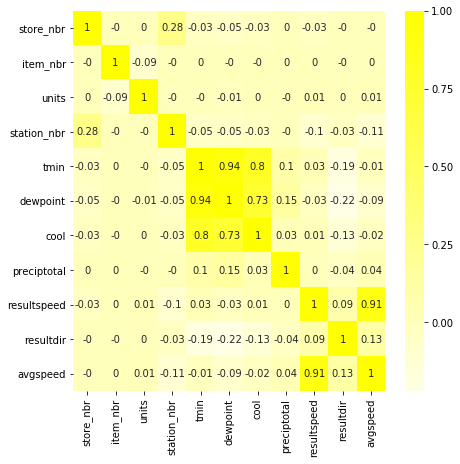

In [942]:
# heatmap 그려주기
# 아직도 tmin, dewpoint, cool 의 상관관계가 높음을 확인 할 수 있음 
import matplotlib.pyplot as plt
cols = df4.columns
plt.figure(figsize = (7,7))
cmap = sns.light_palette("yellow", as_cmap=True) # 위에 한번만 선언하면 됨
sns.heatmap(round(df4[cols].corr(),2), annot=True, cmap=cmap)
plt.show()

In [928]:
# weekday, friday, weekend 값 변수로 넣기
import datetime
def isweekend(dt) : 
    day, month, year = (int(x) for x in dt.split('-'))  
    ans = datetime.date(day, month, year)
    p = datetime.date.weekday(ans)
    if p <= 4 : 
        return 'weekday'
    elif (p == 5) :
        return 'Friday'
    else : 
        return 'weekend'
df4['dayofweek'] = df['date'].apply(isweekend)

In [929]:
# month 로 나눠주기
def month(dt) :
    day, month, year = (int(x) for x in dt.split('-'))  
    return str(month)
df4['month'] = df['date'].apply(month)

In [930]:
# holiday 추가해주기 
with open('/Users/taeahn/Desktop/Team Project/modelling_joseph/holiday_names.txt') as file:  
    data = file.readlines()
    holidays = []
    BF = []
    months = ["", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    for holiday in data : 
        if re.findall("BlackFriday", holiday) != [] :
            BF.append(holiday.split(" ")[:3])
        elif re.findall('Thanksgiving',holiday) != []:
            BF.append(holiday.split(" ")[:3])
        else :
            holidays.append(holiday.split(" ")[:3])
    for i in range(len(holidays)): 
        month_idx = months.index(holidays[i][1])
        if month_idx < 10:
            holidays[i][1] = "0" + str(month_idx)
        else:
            holidays[i][1] = str(month_idx)
    for z in range(len(holidays)) : 
        if len(holidays[z][2]) == 1 : 
            holidays[z][2] = '0' + holidays[z][2]
    for z in range(len(BF)) :
        BF[z][1] = '11'

In [931]:
# holiday 구분하기 
def isholiday(dt): 
    if dt.split("-") in BF :
        return "black friday"
    elif dt.split("-") in holidays :
        return "holiday"
    else :
        return "regular day"

df4['holiday'] = df['date'].apply(isholiday)

In [958]:
# 결과값 csv 로 저장하기 (추후 작업 때 용이함!)
df4.to_csv('walmart_variables.csv' , encoding ='utf-8' )

In [959]:
# 잘 읽어져 오는지 체크! 
df_final = pd.read_csv("../modelling_joseph/walmart_variables.csv")


In [960]:
df_final.head()

,Unnamed: 0,store_nbr,item_nbr,units,station_nbr,tmin,dewpoint,cool,preciptotal,resultspeed,resultdir,avgspeed,dayofweek,month,holiday
0,0,1,1,0,1,31.0,36.0,0.0,0.05,3.6,20.0,4.6,weekend,1,holiday
1,1,1,2,0,1,31.0,36.0,0.0,0.05,3.6,20.0,4.6,weekend,1,holiday
2,2,1,3,0,1,31.0,36.0,0.0,0.05,3.6,20.0,4.6,weekend,1,holiday
3,3,1,4,0,1,31.0,36.0,0.0,0.05,3.6,20.0,4.6,weekend,1,holiday
4,4,1,5,0,1,31.0,36.0,0.0,0.05,3.6,20.0,4.6,weekend,1,holiday
